In [1]:
import pandas as pd
import numpy as np
import env

import matplotlib.pyplot as plt
import seaborn as sns


import env
import gmaps
import gmaps.datasets
import acquire
import wrangle as wr
import exploration as exp
from IPython.display import display

## Acquiring Zillow Data

In [2]:
zillow = acquire.get_zillow_data()
zillow.head()

,Unnamed: 0,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,latitude,longitude
0,0,10759547,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0,34140430.0,-118625364.0
1,1,11193347,0.0,0.0,NaN,10.0,NaN,NaN,6037.0,34585014.0,-118162010.0
2,2,11215747,0.0,0.0,NaN,10.0,NaN,NaN,6037.0,34563376.0,-118019104.0
3,3,11229347,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0,34526913.0,-118050581.0
4,4,11324547,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0,34560018.0,-118169806.0


## Checking/Correcting Null Values

In [3]:
# checking total nulls in each column
zillow.isna().sum()

Unnamed: 0                         0
parcelid                           0
bedroomcnt                        11
bathroomcnt                       11
calculatedfinishedsquarefeet    8485
taxvaluedollarcnt                493
yearbuilt                       9338
taxamount                       4442
fips                               0
latitude                           0
longitude                          0
dtype: int64

In [4]:
# checking number of rows
zillow.shape

(2152864, 11)

In [5]:
# creating proportions to see percentage of nulls in each column
zillow.isna().sum() / zillow.shape[0]

Unnamed: 0                      0.000000
parcelid                        0.000000
bedroomcnt                      0.000005
bathroomcnt                     0.000005
calculatedfinishedsquarefeet    0.003941
taxvaluedollarcnt               0.000229
yearbuilt                       0.004337
taxamount                       0.002063
fips                            0.000000
latitude                        0.000000
longitude                       0.000000
dtype: float64

### Conclusion: 
> Nulls make up very small percent of data set, I feel comfortable dropping them.

In [6]:
# Drop null values and then compare new df shape 
zillow = zillow.dropna()
#zillow = zillow.drop(columns='Unnamed: 0')

# readability
zillow = zillow.rename(columns={'calculatedfinishedsquarefeet': 'sqr_ft'})

zillow.shape[0] / acquire.get_zillow_data().shape[0]

0.9941338607547899

### We still retrain 99.41% of our data with over 2 million rows.

## Checking Data Type Consistency

In [7]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140235 entries, 4 to 2152863
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   parcelid           int64  
 2   bedroomcnt         float64
 3   bathroomcnt        float64
 4   sqr_ft             float64
 5   taxvaluedollarcnt  float64
 6   yearbuilt          float64
 7   taxamount          float64
 8   fips               float64
 9   latitude           float64
 10  longitude          float64
dtypes: float64(9), int64(2)
memory usage: 195.9 MB


### Conclusion:
> All numeric types are already numeric, although fips and yearbuilt would be better as int64.
Will change yearbuilt to int and fips to int, although fips may be dropped eventually.

In [8]:
cols = ['yearbuilt', 'fips']
zillow[cols] = zillow[cols].astype('int64')
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140235 entries, 4 to 2152863
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   parcelid           int64  
 2   bedroomcnt         float64
 3   bathroomcnt        float64
 4   sqr_ft             float64
 5   taxvaluedollarcnt  float64
 6   yearbuilt          int64  
 7   taxamount          float64
 8   fips               int64  
 9   latitude           float64
 10  longitude          float64
dtypes: float64(7), int64(4)
memory usage: 195.9 MB


## Analyzing Weird Values in Dataset

In [9]:
# overview description of values
zillow.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,2140235.0,1.076424e+06,6.214484e+05,4.000000e+00,5.382735e+05,1.076351e+06,1.614604e+06,2.152863e+06
parcelid,2140235.0,1.304843e+07,4.568911e+06,1.071172e+07,1.165653e+07,1.259605e+07,1.405310e+07,1.681836e+08
bedroomcnt,2140235.0,3.301419e+00,9.325998e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,2.500000e+01
bathroomcnt,2140235.0,2.240352e+00,9.905489e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,3.200000e+01
sqr_ft,2140235.0,1.863194e+03,1.221754e+03,1.000000e+00,1.258000e+03,1.623000e+03,2.208000e+03,9.525760e+05
taxvaluedollarcnt,2140235.0,4.606416e+05,6.771576e+05,2.200000e+01,1.891660e+05,3.282960e+05,5.346060e+05,9.018846e+07
yearbuilt,2140235.0,1.960968e+03,2.215056e+01,1.801000e+03,1.949000e+03,1.958000e+03,1.976000e+03,2.016000e+03
taxamount,2140235.0,5.616711e+03,7.814563e+03,6.340000e+00,2.540850e+03,4.111470e+03,6.411930e+03,1.078102e+06
fips,2140235.0,6.048310e+03,2.034491e+01,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
latitude,2140235.0,3.400722e+07,2.480026e+05,3.333991e+07,3.383196e+07,3.400412e+07,3.417018e+07,3.481965e+07


# Takeaways:
> * calculatedfinishedsquarefeet should not have a value of 1.00
> * bedroomcnt + bathroomcnt having 0 is weird but not necessarily impossible. Need further research to see how prevalent this is.


## Cleaning Strange Values

https://worldpopulationreview.com/state-rankings/minimum-house-size-by-state

Using this resource, I'm going to limit the data to only include houses with square footage above 70 square feet.

In [10]:
zillow = zillow[zillow.sqr_ft >= 70]
zillow.shape[0] / acquire.get_zillow_data().shape[0]
zillow

,Unnamed: 0,parcelid,bedroomcnt,bathroomcnt,sqr_ft,taxvaluedollarcnt,yearbuilt,taxamount,fips,latitude,longitude
4,4,11324547,4.0,2.0,3633.0,296425.0,2005,6941.39,6037,34560018.0,-118169806.0
6,6,11544747,3.0,4.0,1620.0,847770.0,2011,10244.94,6037,33996200.0,-118438000.0
7,7,11585547,3.0,2.0,2077.0,646760.0,1926,7924.68,6037,34012977.0,-118479243.0
11,11,11954547,0.0,0.0,1200.0,5328.0,1972,91.60,6037,34097714.0,-118248712.0
14,14,12537947,0.0,0.0,171.0,6920.0,1973,255.17,6037,33770827.0,-118156513.0
...,...,...,...,...,...,...,...,...,...,...,...
2152857,2152857,13027311,4.0,4.0,4375.0,422400.0,2015,13877.56,6037,34137792.0,-117894004.0
2152859,2152859,14356230,4.0,3.0,2262.0,960756.0,2015,13494.52,6059,33687201.0,-117759785.0
2152860,2152860,14157725,4.0,4.5,3127.0,536061.0,2014,6244.16,6059,33929748.0,-117801513.0
2152862,2152862,14367624,3.0,2.5,1974.0,424353.0,2015,5302.70,6059,33645700.0,-117598692.0


Using domain knowledge from Andrew's mom, I'm going to drop all bedroom/bathroom counts of 0.

In [11]:
zillow = zillow[zillow.bedroomcnt != 0]
zillow = zillow[zillow.bathroomcnt != 0.0]
zillow.shape[0] / acquire.get_zillow_data().shape[0]
zillow

,Unnamed: 0,parcelid,bedroomcnt,bathroomcnt,sqr_ft,taxvaluedollarcnt,yearbuilt,taxamount,fips,latitude,longitude
4,4,11324547,4.0,2.0,3633.0,296425.0,2005,6941.39,6037,34560018.0,-118169806.0
6,6,11544747,3.0,4.0,1620.0,847770.0,2011,10244.94,6037,33996200.0,-118438000.0
7,7,11585547,3.0,2.0,2077.0,646760.0,1926,7924.68,6037,34012977.0,-118479243.0
18,18,12716947,3.0,1.0,1244.0,169471.0,1950,2532.88,6037,33953559.0,-118083855.0
19,19,12757147,3.0,2.0,1300.0,233266.0,1950,3110.99,6037,33897134.0,-118102953.0
...,...,...,...,...,...,...,...,...,...,...,...
2152857,2152857,13027311,4.0,4.0,4375.0,422400.0,2015,13877.56,6037,34137792.0,-117894004.0
2152859,2152859,14356230,4.0,3.0,2262.0,960756.0,2015,13494.52,6059,33687201.0,-117759785.0
2152860,2152860,14157725,4.0,4.5,3127.0,536061.0,2014,6244.16,6059,33929748.0,-117801513.0
2152862,2152862,14367624,3.0,2.5,1974.0,424353.0,2015,5302.70,6059,33645700.0,-117598692.0


## Takeaway: 

> Still retain 99.1% of data after dropping null values and cleaning zero values for bathroomcnt/bedroomcnt.

In [12]:
zillow, cats, quants = wr.wrangle_zillow()
zillow.head()

(2134889, 10)
(2096764, 10)


,parcelid,bedroomcnt,bathroomcnt,sqr_ft,taxvaluedollarcnt,yearbuilt,taxamount,county,latitude,longitude
4,11324547,4.0,2.0,3633.0,296425.0,2005.0,6941.39,los_angeles,34560018.0,-118169806.0
6,11544747,3.0,4.0,1620.0,847770.0,2011.0,10244.94,los_angeles,33996200.0,-118438000.0
7,11585547,3.0,2.0,2077.0,646760.0,1926.0,7924.68,los_angeles,34012977.0,-118479243.0
18,12716947,3.0,1.0,1244.0,169471.0,1950.0,2532.88,los_angeles,33953559.0,-118083855.0
19,12757147,3.0,2.0,1300.0,233266.0,1950.0,3110.99,los_angeles,33897134.0,-118102953.0


In [13]:
zillow.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096744 entries, 4 to 2152863
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   parcelid           2096744 non-null  int64  
 1   bedroomcnt         2096744 non-null  float64
 2   bathroomcnt        2096744 non-null  float64
 3   sqr_ft             2096744 non-null  float64
 4   taxvaluedollarcnt  2096744 non-null  float64
 5   yearbuilt          2096744 non-null  float64
 6   taxamount          2096744 non-null  float64
 7   county             2096744 non-null  object 
 8   latitude           2096744 non-null  float64
 9   longitude          2096744 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 176.0+ MB


## Final Dataset:

In [14]:
zillow.head()
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096744 entries, 4 to 2152863
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   parcelid           int64  
 1   bedroomcnt         float64
 2   bathroomcnt        float64
 3   sqr_ft             float64
 4   taxvaluedollarcnt  float64
 5   yearbuilt          float64
 6   taxamount          float64
 7   county             object 
 8   latitude           float64
 9   longitude          float64
dtypes: float64(8), int64(1), object(1)
memory usage: 176.0+ MB


# Proportion of data left after cleaning using following assumptions:
 > * minimum square feet >= 70 ft
 > * minimum square ft calculated also by bthroomcnt * 10 sqr ft 
added to bedroomcnt * 70 sqr ft
 > * all numeric values with z scores over 3.5 taken out

In [15]:
zillow.shape[0] / acquire.get_zillow_data().shape[0]

0.9739323988881787

## Final:
> 97.40% data left after cleaning data / purging extreme values.

## Visualizations of Univariate Distributions

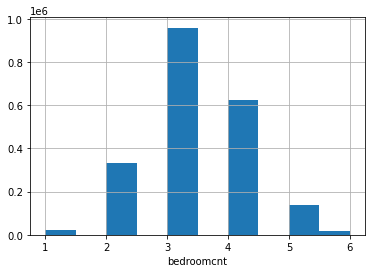

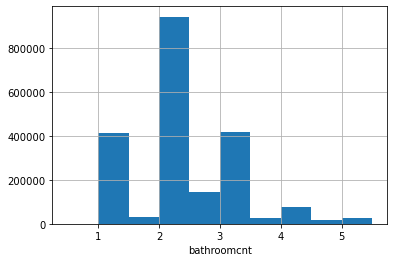

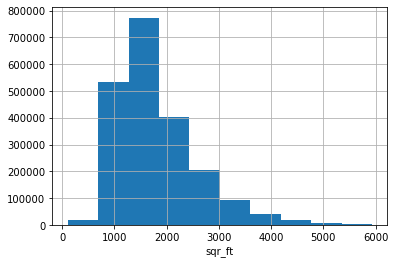

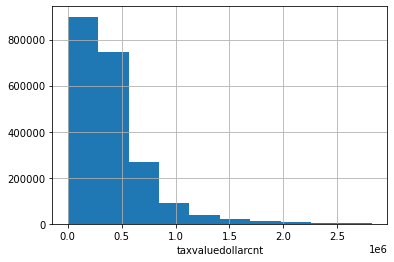

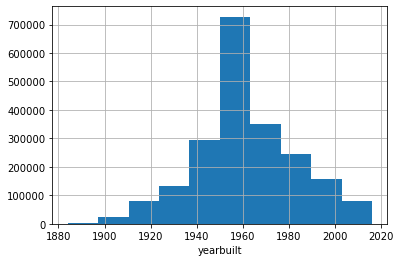

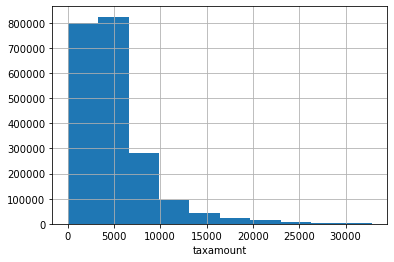

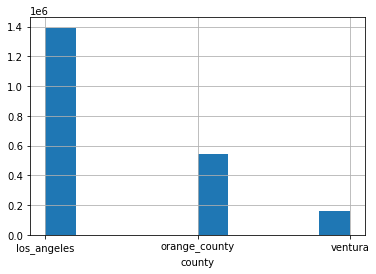

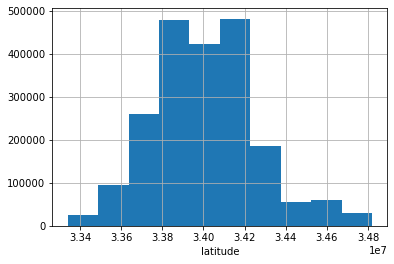

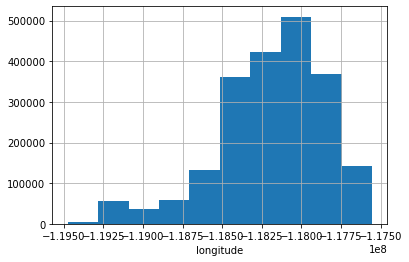

In [16]:
cols_to_visualize = zillow.drop(columns='parcelid').columns
for col in cols_to_visualize:
    exp.target_freq_hist_count(zillow, col)
    plt.xlabel(col)
    plt.show()
    
df = zillow.copy()

In [17]:
def county_borders(df, resolution):
    zillow = df.copy()
    border_dict = {}
    grids = []
    prices = []
    
    zillow.latitude = zillow.latitude / 1000000
    zillow.longitude = zillow.longitude / 1000000
    
    for county in zillow.county.unique():
        border_dict[f'{county}_lat_min'] = zillow[zillow.county == county].latitude.min()
        border_dict[f'{county}_lat_max'] = zillow[zillow.county == county].latitude.max()
        border_dict[f'{county}_lon_min'] = zillow[zillow.county == county].longitude.min()
        border_dict[f'{county}_lon_max'] = zillow[zillow.county == county].longitude.max()
        
        #print(border_dict)
        
        border_dict = lat_lon_steps(border_dict, zillow, resolution, county)
        
        border_dict[f'{county}_lat'] = np.arange(border_dict[f'{county}_lat_min'], 
                                                 border_dict[f'{county}_lat_max'],
                                                 border_dict[f'{county}_lat_step'])
        
        
        border_dict[f'{county}_lon'] = np.arange(border_dict[f'{county}_lon_min'],
                                                 border_dict[f'{county}_lon_max'],
                                                 border_dict[f'{county}_lon_step'])
        
    return border_dict
    


def lat_lon_steps(border_dict, zillow, resolution, county):
    
    border_dict[f'{county}_lat_step'] = (border_dict[f'{county}_lat_max'] - border_dict[f'{county}_lat_min']) / resolution
    border_dict[f'{county}_lon_step'] = (border_dict[f'{county}_lon_max'] - border_dict[f'{county}_lon_min']) / resolution

    return border_dict

def create_grids(border_dict, resolution, df, sample=30_000):
    grids = []
    prices = []
    lat_coords = []
    lon_coords = []
    sqr_ft = []
    added = 0
    
    if sample:
        zillow = df.sample(sample)
        
    else:
        zillow = df
    zillow.latitude = zillow.latitude/ 1000000
    zillow.longitude = zillow.longitude / 1000000
    
    for i, county in enumerate(np.sort(zillow.county.unique())):
        grids.append(np.zeros((resolution, resolution)))
        prices.append(np.zeros((resolution, resolution)))
        lat_coords.append(np.zeros((resolution,resolution)))
        lon_coords.append(np.zeros((resolution,resolution)))
        sqr_ft.append(np.zeros((resolution,resolution)))
        
        county_subset = zillow[zillow.county == county]
        print(county)
        
        for a in range(len(county_subset)):
            
            for b1 in range(resolution):
                if border_dict[f'{county}_lat'][b1] - (border_dict[f'{county}_lat_step']/2) <= county_subset.latitude.values[a] < border_dict[f'{county}_lat'][b1] + (border_dict[f'{county}_lat_step'] /2):
                
                    for b2 in range(resolution):
                        if border_dict[f'{county}_lon'][b2] - (border_dict[f'{county}_lon_step']/2) <= county_subset.longitude.values[a] < border_dict[f'{county}_lon'][b2] + (border_dict[f'{county}_lon_step']/2):

                            prices[i][b1, b2] += county_subset.taxvaluedollarcnt.values[a]
                            grids[i][b1, b2] += 1
                            sqr_ft[i][b1,b2] += county_subset.sqr_ft.values[a]
                            lat_coords[i][b1, b2] = border_dict[f'{county}_lat'][b1]
                            lon_coords[i][b1, b2] = border_dict[f'{county}_lon'][b2]
                            break
                    break
                            
            added += 1
            if added % (sample/5) == 0:
                print(added)
        #print(grids[i])
    
    return grids, prices, lat_coords, lon_coords, sqr_ft, resolution


def create_map_data(df, resolution, sample=30_000):
    border_dict = county_borders(df, resolution)
    grids, prices, lat_coords, lon_coords, sqr_ft, resolution = create_grids(border_dict, resolution, 
                                                                                 df, sample=sample)
    
    return prices, grids, lat_coords, lon_coords, sqr_ft, resolution
  

In [18]:
def create_display_heatmap(prices, grid, lat_coords, lon_coords, sqr_ft, resolution, 
                           counties=['la'], option='average_price'):
    
    county_dfs = []
    
    api_key = env.gmaps_api()
    gmaps.configure(api_key=api_key)
    
    for county in counties:
        i = 0
        if county == 'oc':
            i = 1
        elif county == 'ventura':
            i = 2
        
        county_latitude_values = lat_coords[i].reshape((resolution**2,))
        county_longitude_values = lon_coords[i].reshape((resolution**2,))
        county_prices = prices[i].reshape((resolution**2,))
        county_grid = grids[i].reshape((resolution**2,))
        county_sqr_ft = sqr_ft[i].reshape((resolution**2,))

        heatmap_prices = {'county_prices': county_prices, 'latitude': county_latitude_values, 
                          'longitude': county_longitude_values, 'num_houses': county_grid,
                          'sqr_ft': county_sqr_ft}

        county_df =pd.DataFrame(heatmap_prices)
        county_df = county_df[county_df.num_houses > 0]

        county_df['avg_prices'] = county_df.county_prices / county_df.num_houses
        county_df['price_per_sqr_ft'] = county_df.county_prices / county_df.sqr_ft
        print(county_df.price_per_sqr_ft.max())
        
        county_dfs.append(county_df)

        locations = county_df[['latitude', 'longitude']]
        
        options = {'average_price': county_df['avg_prices'], 'price_per_sqr_ft': county_df['price_per_sqr_ft']}
        weights = options[option]

        fig = gmaps.figure()
        heatmap_layer = gmaps.heatmap_layer(county_df[['latitude', 'longitude']], weights=weights, 
                                            max_intensity=county_df.price_per_sqr_ft.max(), point_radius=1.2)

        fig.add_layer(gmaps.heatmap_layer(county_df[['latitude', 'longitude']], weights=weights))
        display(fig)
        
    return county_dfs
    

In [19]:
prices, grids, lat_coords, lon_coords, sqr_ft, resolution = exp.create_map_data(df, resolution=100,
                                                                            sample=10_000)



los_angeles
2000
4000
6000
orange_county
8000
ventura
10000


In [20]:
county_dfs = exp.create_display_heatmap(prices, grids, lat_coords, lon_coords, sqr_ft, resolution,
                       counties=['la', 'oc', 'ventura'], option='price_per_sqr_ft')

1021.7903938167096


Figure(layout=FigureLayout(height='420px'))

4724.879120879121


Figure(layout=FigureLayout(height='420px'))

981.0916874777024


Figure(layout=FigureLayout(height='420px'))

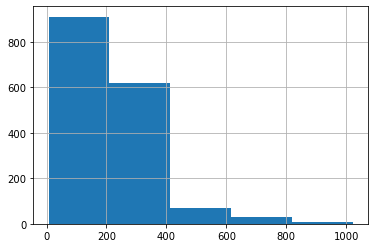

,county_prices,latitude,longitude,num_houses,sqr_ft,avg_prices,price_per_sqr_ft,price_range
47,600000.0,33.339912,-118.325642,1.0,1288.0,600000.000000,465.838509,expensive
2548,1228180.0,33.709846,-118.312935,2.0,4546.0,614090.000000,270.167180,pricey
2550,2921631.0,33.709846,-118.287520,3.0,6886.0,973877.000000,424.285652,pricey
2647,2190852.0,33.724644,-118.325642,3.0,6364.0,730284.000000,344.257071,pricey
2648,3707587.0,33.724644,-118.312935,6.0,11460.0,617931.166667,323.524171,pricey


In [21]:
limit = county_dfs[0].price_per_sqr_ft.max()
intervals = np.arange(0, limit+ (limit/5), limit/6)

fig = county_dfs[0].price_per_sqr_ft.hist(bins=5)
fig.xticks = intervals
plt.show()

# 0 - 215         average
# 216 - 440       pricey
# 441 - limit     expensive

def range_values(series):
    if 0 < series <= 215:
        return 'average'
    elif 215 < series <= 440:
        return 'pricey'
    elif 440 < series:
        return 'expensive'

county_dfs[0]['price_range'] = ''
county_dfs[0].price_range = county_dfs[0].price_per_sqr_ft.apply(range_values)
county_dfs[0].head()


<AxesSubplot:xlabel='latitude', ylabel='longitude'>

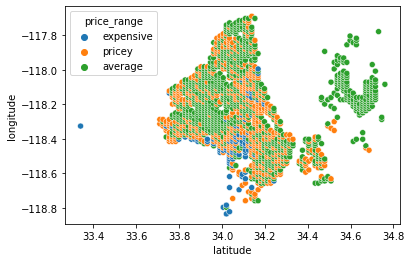

In [22]:
sns.scatterplot(data=county_dfs[0], x=county_dfs[0].latitude, y=county_dfs[0].longitude, hue='price_range')

In [23]:
#zillow = zillow.taxvaluedollarcnt.apply(range_values)
zillow['price_per_sqr_ft'] = zillow.taxvaluedollarcnt/zillow.sqr_ft
zillow['price_range'] = zillow.price_per_sqr_ft.apply(range_values)
zillow

,parcelid,bedroomcnt,bathroomcnt,sqr_ft,taxvaluedollarcnt,yearbuilt,taxamount,county,latitude,longitude,price_per_sqr_ft,price_range
4,11324547,4.0,2.0,3633.0,296425.0,2005.0,6941.39,los_angeles,34560018.0,-118169806.0,81.592348,average
6,11544747,3.0,4.0,1620.0,847770.0,2011.0,10244.94,los_angeles,33996200.0,-118438000.0,523.314815,expensive
7,11585547,3.0,2.0,2077.0,646760.0,1926.0,7924.68,los_angeles,34012977.0,-118479243.0,311.391430,pricey
18,12716947,3.0,1.0,1244.0,169471.0,1950.0,2532.88,los_angeles,33953559.0,-118083855.0,136.230707,average
19,12757147,3.0,2.0,1300.0,233266.0,1950.0,3110.99,los_angeles,33897134.0,-118102953.0,179.435385,average
...,...,...,...,...,...,...,...,...,...,...,...,...
2152857,13027311,4.0,4.0,4375.0,422400.0,2015.0,13877.56,los_angeles,34137792.0,-117894004.0,96.548571,average
2152859,14356230,4.0,3.0,2262.0,960756.0,2015.0,13494.52,orange_county,33687201.0,-117759785.0,424.737401,pricey
2152860,14157725,4.0,4.5,3127.0,536061.0,2014.0,6244.16,orange_county,33929748.0,-117801513.0,171.429805,average
2152862,14367624,3.0,2.5,1974.0,424353.0,2015.0,5302.70,orange_county,33645700.0,-117598692.0,214.971125,average


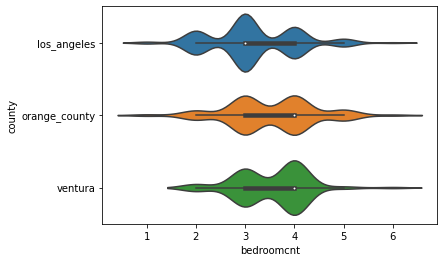

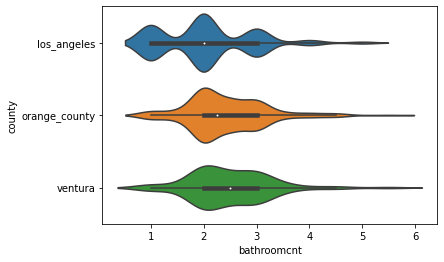

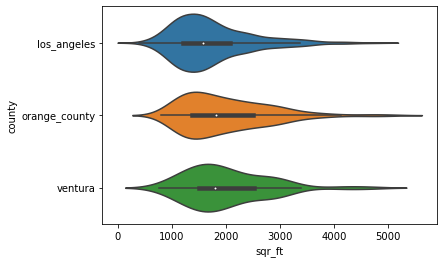

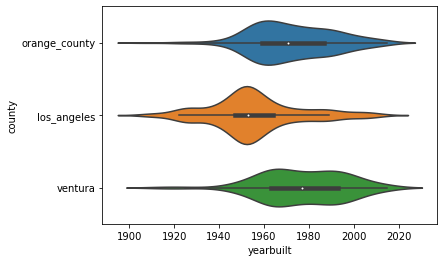

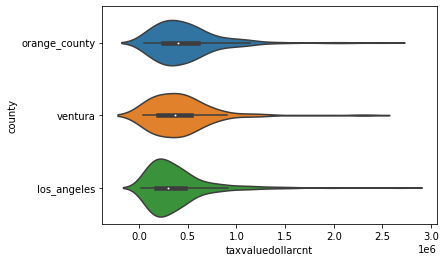

In [24]:
continuous = ['bedroomcnt', 'bathroomcnt', 'sqr_ft', 'yearbuilt', 'taxvaluedollarcnt']

exp.plot_categorical_and_continuous_vars(zillow, continuous, cats)
